In [1]:
%pwd

u'/home/shared/srp'

In [2]:
%pylab inline

/home/femianjc/anaconda2/envs/srp/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib



# Setup

On Ubuntu, I set up my environment like this:

```#!bash

    conda config --add channels conda-forge
    conda create -n srp python=2
    
    source activate srp
    conda install -y anaconda
    conda install -y laspy
    conda install -y fiona
    conda install -y shapely
    conda install -y rasterio
    pip install tqdm
```


In [3]:
import os
import laspy
import fiona
import shapely
import rasterio
from pprint import pprint
from tqdm import tnrange

In [4]:
LIDAR_SOURCE_FN = (r'/mnt/wwn-0x5000c5008aadf02c-part2/ASU_LiDAR_Processing/'+
                   r'section11/tiled/100/tile_232100_252400.laz')
assert os.path.isfile(LIDAR_SOURCE_FN)

In [5]:
VECTOR_DATA_FN = r'/home/liux13/Desktop/tmp/boxes_section11.shp'
assert os.path.isfile(VECTOR_DATA_FN)

In [6]:
GROUND_FN = r'/mnt/wwn-0x5000c5008aadf02c-part2/ASU_LiDAR_Processing/section11/merged_ground.asc'
assert os.path.isfile(GROUND_FN)

In [7]:
OUTPUT_METERS_PER_PIXEL = .05 # five centimeters, about 2 inches
OUTPUT_PADDING = 5 # expand output region 5  meters (to fit a local neighborhood into the image at the edges)

# Open the vector Data
The vector data is used to determine the region of inters

In [8]:
vector_file = fiona.open(VECTOR_DATA_FN)

In [9]:
minx, miny, maxx, maxy = vector_file.bounds

# Expand the region so that a local windo centered at points on the edges
# does not goi outside the grid
minx -= OUTPUT_PADDING
miny -= OUTPUT_PADDING
maxx += OUTPUT_PADDING
maxy += OUTPUT_PADDING

print "Region of interest (based on vector data)"
print minx, miny, "--", maxx, maxy 

Region of interest (based on vector data)
231638.410976 251008.999357 -- 233216.25982 252568.834735


In [10]:
width_in_meters = maxx-minx
height_in_meters = maxy-miny
print 'width (m):', width_in_meters
print 'height (m):', height_in_meters

width (m): 1577.84884394
height (m): 1559.83537839


In [11]:
grid_width = int(round(width_in_meters/OUTPUT_METERS_PER_PIXEL))
grid_height = int(round(height_in_meters/OUTPUT_METERS_PER_PIXEL))
print 'grid width (cols):', grid_width
print 'grid height (rows):', grid_height

grid width (cols): 31557
grid height (rows): 31197


# Open the LiDAR data

In [12]:
las_file = laspy.file.File(LIDAR_SOURCE_FN)

In [13]:
X = las_file.x
Y = las_file.y
Z = las_file.z

In [14]:
print "This file has {:,d} points".format(las_file.header.count)

This file has 117,196,289 points


In [15]:
min_point = las_file.header.min
max_point = las_file.header.max
print min_point
print max_point

[232100.00051125194, 252400.0000879348, 386.9107121991307]
[232199.99951125192, 252499.9990879348, 444.8737121991307]


In [16]:
print 'las file width (m):', max_point[0]-min_point[0]
print 'las file height (m):', max_point[1]-min_point[1]
print 'las file depth (m):', max_point[2]-min_point[2]

las file width (m): 99.999
las file height (m): 99.999
las file depth (m): 57.963


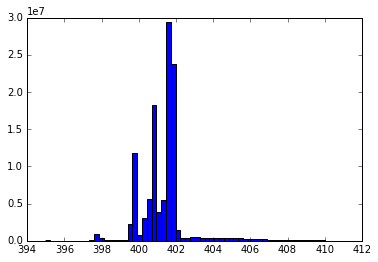

In [17]:
hist(Z, bins=58, range=(395,410));

In [18]:
las_min_x = int(floor((min_point[0]-minx) / OUTPUT_METERS_PER_PIXEL))
las_min_y = int(floor((min_point[1]-miny) / OUTPUT_METERS_PER_PIXEL))
print 'las file min x (on grid):', las_min_x
print 'las file min y (on grid):', las_min_y

las_max_x = int(floor((max_point[0]-minx) / OUTPUT_METERS_PER_PIXEL))
las_max_y = int(floor((max_point[1]-miny) / OUTPUT_METERS_PER_PIXEL))
print 'las file max x (on grid):', las_max_x
print 'las file max y (on grid):', las_max_y

las_width = las_max_x - las_min_x+1
las_height = las_max_y - las_min_y+1
print 'las file grid width (cols):', las_width
print 'las file grid height (rows):', las_height

las file min x (on grid): 9231
las file min y (on grid): 27820
las file max x (on grid): 11231
las file max y (on grid): 29819
las file grid width (cols): 2001
las file grid height (rows): 2000


##  Change the height to be above the ground. 

In [19]:
ground_file = rasterio.open(GROUND_FN)
pprint(ground_file.meta)

{'affine': Affine(0.5, 0.0, 231302.0,
       0.0, -0.5, 252844.5),
 'count': 1,
 'crs': {},
 'driver': u'AAIGrid',
 'dtype': 'float32',
 'height': 4386,
 'nodata': -9999.0,
 'transform': (231302.0, 0.5, 0.0, 252844.5, 0.0, -0.5),
 'width': 4369}


In [20]:
ground_min_x, ground_min_y = ~(ground_file.affine)*(min_point[0], min_point[1])
ground_max_x, ground_max_y = ~(ground_file.affine)*(max_point[0], max_point[1])

ground_min_x = int(round(ground_min_x))
ground_min_y = int(round(ground_min_y))
ground_max_x = int(round(ground_max_x))
ground_max_y = int(round(ground_max_y))

flipped = False
if ground_max_y <  ground_min_y:
    ground_min_y, ground_max_y = ground_max_y, ground_min_y
    flipped = True
print 'min xy (or cr):', ground_min_x, ground_min_y
print 'max xy (or cr):', ground_max_x, ground_max_y

ground_width = ground_max_x-ground_min_x+1
ground_height = ground_max_y - ground_min_y+1
print "ground width:", ground_width
print "ground height:", ground_height

min xy (or cr): 1596 689
max xy (or cr): 1796 889
ground width: 201
ground height: 201


In [21]:
ground = ground_file.read(1, window=((ground_min_y, ground_max_y+1), (ground_min_x, ground_max_x+1)))
if flipped:
    ground = ground[::-1,:]
print ground.shape

(201, 201)


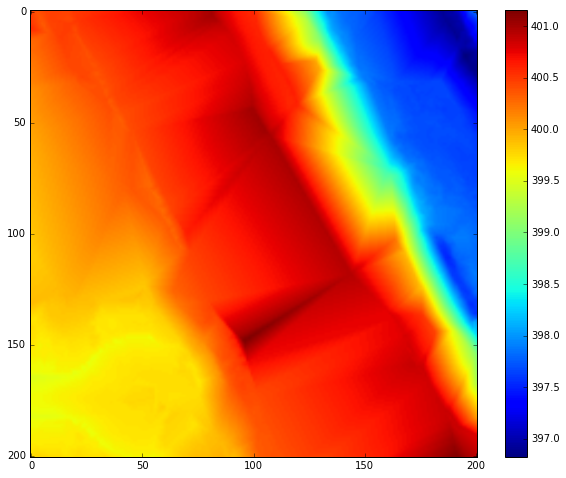

In [22]:
figsize(10, 8)
imshow(ground)
colorbar();

In [23]:
C = ((X - minx)/OUTPUT_METERS_PER_PIXEL).astype(int) - las_min_x
R = ((Y - miny)/OUTPUT_METERS_PER_PIXEL).astype(int) - las_min_y
print C
print R

[1996 1994 1995 ..., 1994 1993 1992]
[   1   12   28 ..., 1801 1800 1800]


In [24]:
ground_z = ground[(R*ground_height)/las_height, (C*ground_width)/las_width]

In [25]:
height_above_ground = Z - ground_z

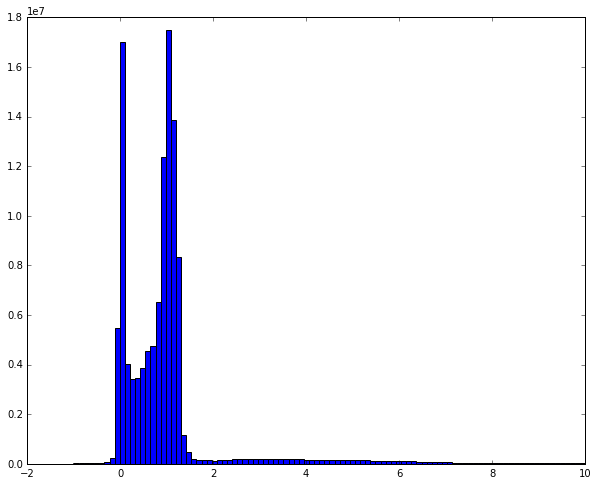

In [26]:
hist(height_above_ground, bins=100, range=(-1, 10));

## mask out the range of heights we are interested in

In [27]:
SLICE_THICKNESS = 0.313
level = np.floor((height_above_ground)/SLICE_THICKNESS).astype(int)

In [28]:
lvl = 1       
bc = np.bincount(R[level==lvl]*las_width + C[level==lvl], minlength=las_width*las_height)

In [29]:
output = bc.reshape((las_height, las_width))

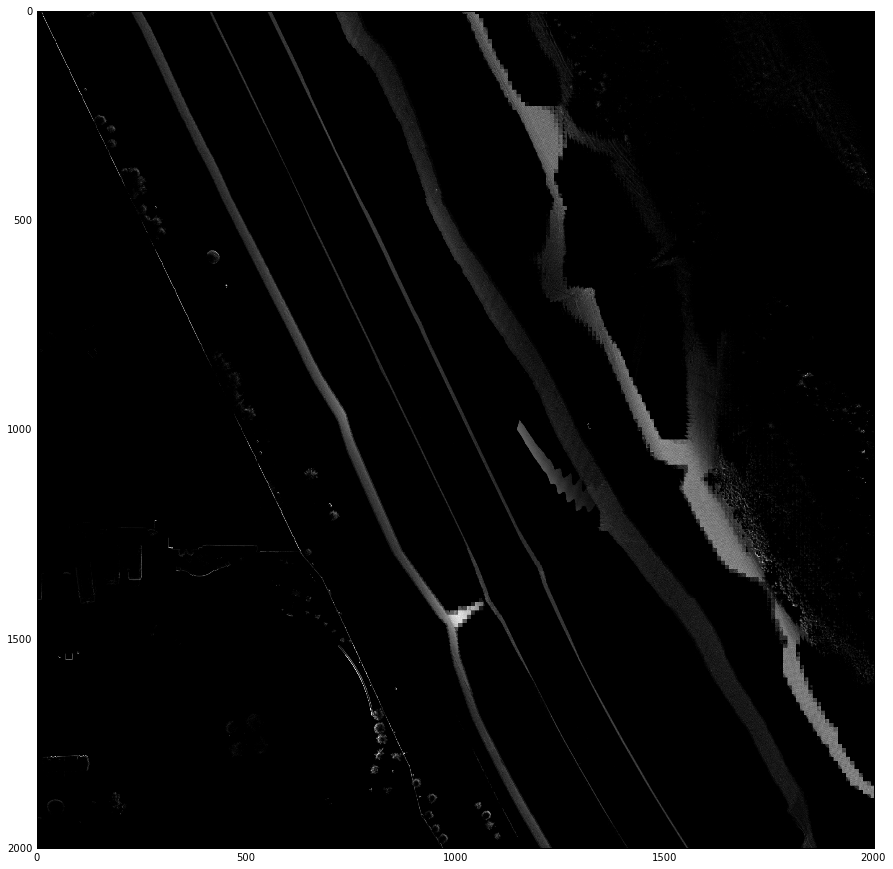

In [30]:
figsize(15,15)
imshow(output, vmax=140, cmap=cm.gray)

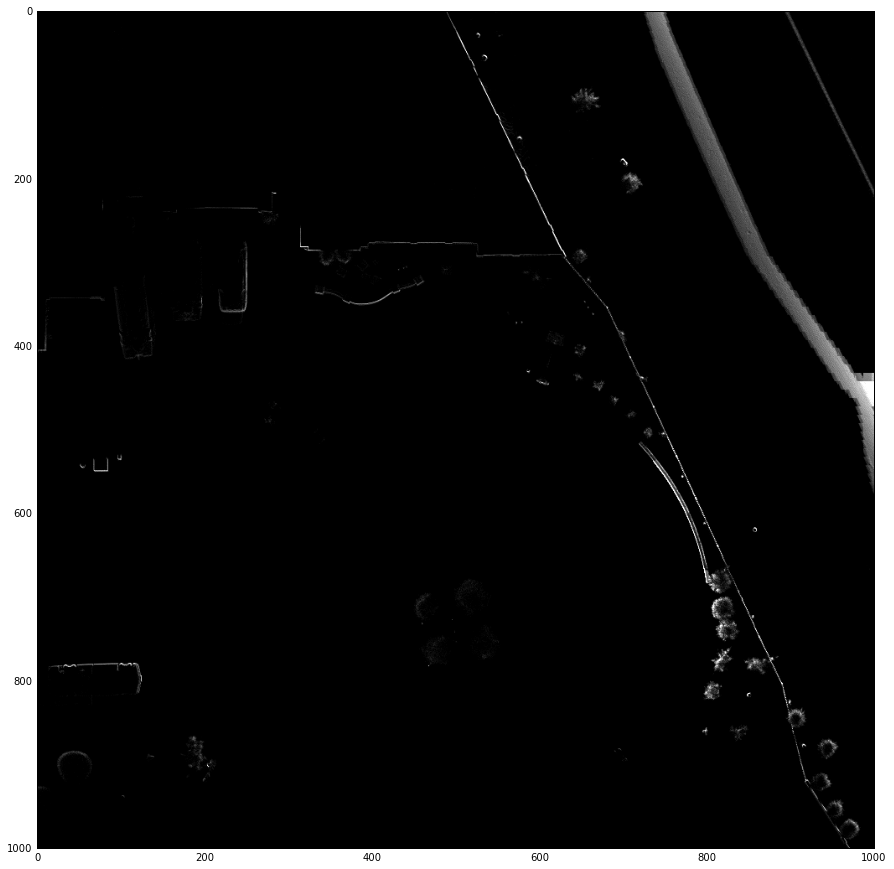

In [31]:
figsize(15,15)
imshow(output[1000:2000, 0:1000], vmax=100, cmap=cm.gray)

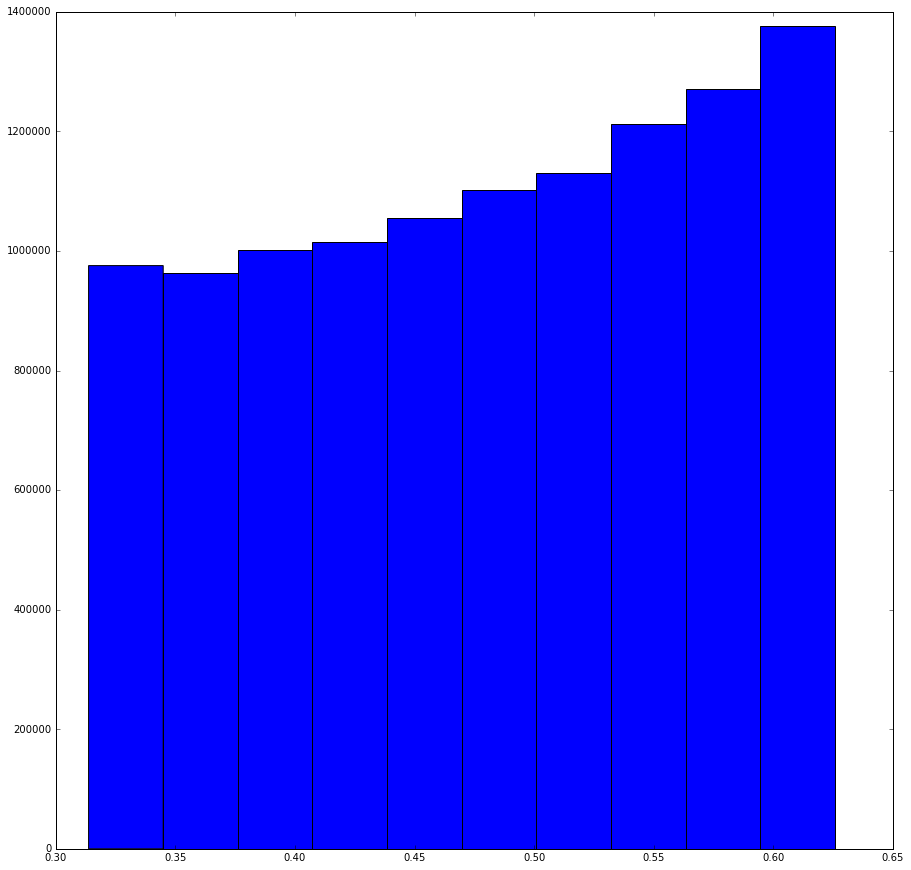

In [32]:
hist(height_above_ground[level==lvl], bins=10);

In [33]:
def generate_level(lvl):
    bc = np.bincount(R[level==lvl]*las_width + C[level==lvl], minlength=las_width*las_height)
    output = bc.reshape((las_height, las_width)).astype(float)
    return output

stack = np.stack([generate_level(lvl) for lvl in 1,2,3])

In [34]:
print stack[stack>0].min(), stack.max()
scaling = np.median(stack[stack>0])
print scaling 

1.0 530.0
34.0


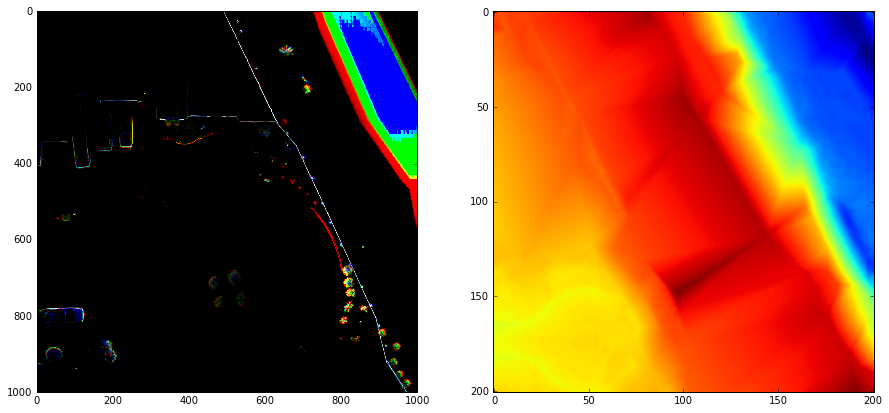

In [35]:
stack_rgb = (stack.transpose(1,2,0)/scaling).clip(0,1)

subplot(1,2,1)
imshow(stack_rgb[1000:2000, 0:1000])
subplot(1,2,2)
imshow(ground)

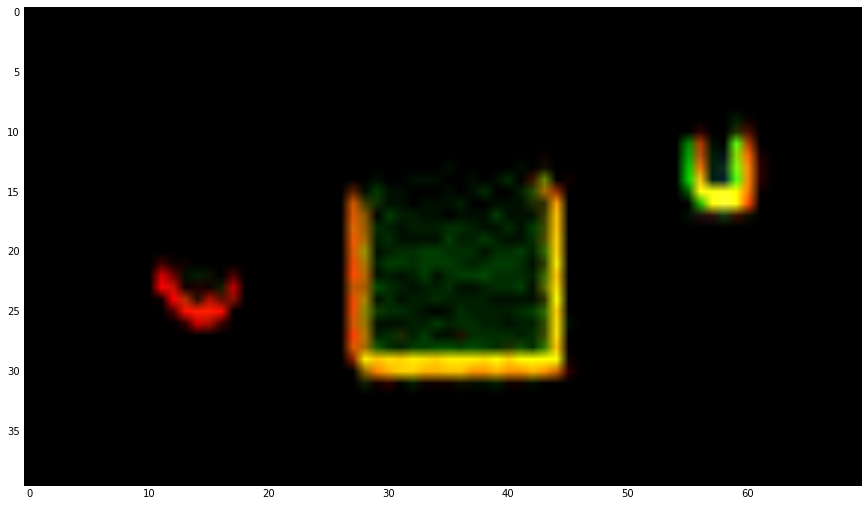

In [36]:
imshow(stack_rgb[1520:1560, 40:110,:])

# Generate Grid For Whole Region Dataset

## Now read in each .las file, and write resulte back out (added)

In [37]:
OUTPUT_FN = './stack.vrt'

In [38]:
import rasterio.crs

In [39]:
from tqdm import tnrange, tqdm
from glob import glob
from time import sleep

In [40]:
pattern = os.path.join(os.path.split(LIDAR_SOURCE_FN)[0],'*.laz')
las_files = glob(pattern)
print len(las_files)

471


In [41]:
def save_stack(stack, las_fn, min_point, max_point, las_width, las_height):
    output_transform = rasterio.transform.from_bounds(min_point[0], min_point[1],
                                                      max_point[0], max_point[1], 
                                                      las_width, las_height)
    output_crs = rasterio.crs.from_epsg(26949)

    output_fn = os.path.split(las_fn)[1][:-3] + 'tif'
    if os.path.isfile(output_fn):
        os.remove(output_fn)
        
    output_file = rasterio.open(output_fn, 'w', 
                            driver=u'GTiff', 
                            crs = output_crs,
                            transform=output_transform,
                            dtype=rasterio.uint16, 
                            count=3, 
                            width=las_width, 
                            height=las_height)
    
    output_file.write(indexes=(1,2,3), src=stack.astype(np.uint16))
    
    output_file.close()
    return output_fn

save_stack(stack[:,::-1,:], LIDAR_SOURCE_FN, min_point, max_point, las_width, las_height)

'tile_232100_252400.tif'

In [42]:
import traceback

In [43]:
def process_las_file(las_fn):
    """Processes a single LAS/LAZ file
    This function either returns the name of a file, or an exception object. 
    It is intended to be used in multiprocwesing.Pool.imap
    """
    output_fn = ''
    try:
        print las_fn
        las_file = laspy.file.File(las_fn)
        X = las_file.x
        Y = las_file.y
        Z = las_file.z
        #print "This file has {:,d} points".format(las_file.header.count)

        min_point = las_file.header.min
        max_point = las_file.header.max

        #print 'las file width (m):', max_point[0]-min_point[0]
        #print 'las file height (m):', max_point[1]-min_point[1]
        #print 'las file depth (m):', max_point[2]-min_point[2]


        las_min_x = int(floor((min_point[0]-minx) / OUTPUT_METERS_PER_PIXEL))
        las_min_y = int(floor((min_point[1]-miny) / OUTPUT_METERS_PER_PIXEL))
        #print 'las file min x (on grid):', las_min_x
        #print 'las file min y (on grid):', las_min_y

        las_max_x = int(floor((max_point[0]-minx) / OUTPUT_METERS_PER_PIXEL))
        las_max_y = int(floor((max_point[1]-miny) / OUTPUT_METERS_PER_PIXEL))
        #print 'las file max x (on grid):', las_max_x
        #print 'las file max y (on grid):', las_max_y

        if max_point[0] < minx or min_point[0] > maxx or max_point[1] < miny or min_point[1] > maxy:
            #print "Skipping out-of-bounds file"
            return "Skipping {}, out-of-bounds file".format(os.path.split(las_fn)[1])

        las_width = las_max_x - las_min_x+1
        las_height = las_max_y - las_min_y+1
        #print 'las file grid width (cols):', las_width
        #print 'las file grid height (rows):', las_height


        ground_file = rasterio.open(GROUND_FN)
        ground_min_x, ground_min_y = ~(ground_file.affine)*(min_point[0], min_point[1])
        ground_max_x, ground_max_y = ~(ground_file.affine)*(max_point[0], max_point[1])
        ground_min_x = int(round(ground_min_x))
        ground_min_y = int(round(ground_min_y))
        ground_max_x = int(round(ground_max_x))
        ground_max_y = int(round(ground_max_y))

        flipped = False
        if ground_max_y <  ground_min_y:
            ground_min_y, ground_max_y = ground_max_y, ground_min_y
            flipped = True
        #print 'min xy (or cr):', ground_min_x, ground_min_y
        #print 'max xy (or cr):', ground_max_x, ground_max_y

        ground_width = ground_max_x-ground_min_x + 1
        ground_height = ground_max_y - ground_min_y + 1
        #print "ground width:", ground_width
        #print "ground height:", ground_height  

        ground = ground_file.read(1, window=((ground_min_y, ground_max_y+1), (ground_min_x, ground_max_x+1)), 
                                  boundless=True)
        if flipped:
            ground = ground[::-1,:] 
        ground_file.close()

        assert (ground.shape[0] == ground_height)

        C = np.floor(((X - minx)/OUTPUT_METERS_PER_PIXEL)).astype(int) - las_min_x
        R = np.floor(((Y - miny)/OUTPUT_METERS_PER_PIXEL)).astype(int) - las_min_y

        ground_z = ground[(R*ground_height)/las_height, (C*ground_width)/las_width]    
        height_above_ground = Z - ground_z    

        level = np.floor((height_above_ground)/SLICE_THICKNESS).astype(int)

        def _generate_level(lvl):
            bc = np.bincount(R[level==lvl]*las_width + C[level==lvl], minlength=las_width*las_height)
            output = bc.reshape((las_height, las_width)).astype(float)
            return output

        stack = np.stack([_generate_level(lvl) for lvl in 1,2,3])

        # I seem to be working upside-down...
        output_fn = save_stack(stack[:,::-1,:], las_fn,  min_point, max_point, las_width, las_height)

        las_file.close()
    except e:
        return (e, traceback.format_exc())
    
    return output_fn
    

In [44]:
process_las_file(las_files[41])

/mnt/wwn-0x5000c5008aadf02c-part2/ASU_LiDAR_Processing/section11/tiled/100/tile_231500_250600.laz


'Skipping tile_231500_250600.laz, out-of-bounds file'

In [46]:
from tqdm import tqdm_notebook
from multiprocessing import Pool, cpu_count

print cpu_count()

40


In [61]:
jobs = las_files #[:10]
pprint(jobs)

['/mnt/wwn-0x5000c5008aadf02c-part2/ASU_LiDAR_Processing/section11/tiled/100/tile_231500_251100.laz',
 '/mnt/wwn-0x5000c5008aadf02c-part2/ASU_LiDAR_Processing/section11/tiled/100/tile_231200_252000.laz',
 '/mnt/wwn-0x5000c5008aadf02c-part2/ASU_LiDAR_Processing/section11/tiled/100/tile_231200_252100.laz',
 '/mnt/wwn-0x5000c5008aadf02c-part2/ASU_LiDAR_Processing/section11/tiled/100/tile_231200_252500.laz',
 '/mnt/wwn-0x5000c5008aadf02c-part2/ASU_LiDAR_Processing/section11/tiled/100/tile_231300_250700.laz',
 '/mnt/wwn-0x5000c5008aadf02c-part2/ASU_LiDAR_Processing/section11/tiled/100/tile_231300_250800.laz',
 '/mnt/wwn-0x5000c5008aadf02c-part2/ASU_LiDAR_Processing/section11/tiled/100/tile_231300_250900.laz',
 '/mnt/wwn-0x5000c5008aadf02c-part2/ASU_LiDAR_Processing/section11/tiled/100/tile_231300_251000.laz',
 '/mnt/wwn-0x5000c5008aadf02c-part2/ASU_LiDAR_Processing/section11/tiled/100/tile_231300_251200.laz',
 '/mnt/wwn-0x5000c5008aadf02c-part2/ASU_LiDAR_Processing/section11/tiled/100/tile_

In [73]:
workers.terminate()

In [78]:
pbar = tqdm_notebook(total=len(jobs))
completed = []

In [82]:
pattern = os.path.join(r'/mnt/wwn-0x5000c5008aadf02c-part2/ASU_LiDAR_Processing/section11/tiled/50/*.laz')
jobs = glob(pattern)
pprint(jobs)

['/mnt/wwn-0x5000c5008aadf02c-part2/ASU_LiDAR_Processing/section11/tiled/50/tile_231200_252550.laz',
 '/mnt/wwn-0x5000c5008aadf02c-part2/ASU_LiDAR_Processing/section11/tiled/50/tile_231250_251350.laz',
 '/mnt/wwn-0x5000c5008aadf02c-part2/ASU_LiDAR_Processing/section11/tiled/50/tile_231250_251400.laz',
 '/mnt/wwn-0x5000c5008aadf02c-part2/ASU_LiDAR_Processing/section11/tiled/50/tile_231250_251750.laz',
 '/mnt/wwn-0x5000c5008aadf02c-part2/ASU_LiDAR_Processing/section11/tiled/50/tile_231250_251850.laz',
 '/mnt/wwn-0x5000c5008aadf02c-part2/ASU_LiDAR_Processing/section11/tiled/50/tile_231250_252000.laz',
 '/mnt/wwn-0x5000c5008aadf02c-part2/ASU_LiDAR_Processing/section11/tiled/50/tile_231250_252050.laz',
 '/mnt/wwn-0x5000c5008aadf02c-part2/ASU_LiDAR_Processing/section11/tiled/50/tile_231250_252550.laz',
 '/mnt/wwn-0x5000c5008aadf02c-part2/ASU_LiDAR_Processing/section11/tiled/50/tile_231300_250750.laz',
 '/mnt/wwn-0x5000c5008aadf02c-part2/ASU_LiDAR_Processing/section11/tiled/50/tile_231300_250

In [84]:
import gc
gc.collect()

0

In [ ]:
workers = Pool(processes=20)
completed =[]
for output_fn in workers.imap(process_las_file, jobs):
    print output_fn
    completed.append(output_fn)
    pbar.update(1)
workers.terminate()
workers.close()

Process PoolWorker-336:
Process PoolWorker-335:
Process PoolWorker-334:
Process PoolWorker-333:
Process PoolWorker-339:
Process PoolWorker-324:
Process PoolWorker-323:
Process PoolWorker-325:
Process PoolWorker-330:
Process PoolWorker-332:
Process PoolWorker-328:
Process PoolWorker-338:
Process PoolWorker-340:
Process PoolWorker-342:
Process PoolWorker-326:
Process PoolWorker-341:
Process PoolWorker-331:
Process PoolWorker-329:
Process PoolWorker-327:
Process PoolWorker-337:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call la

In [ ]:
pbar.close()

In [77]:
import psutil
for pis in range(9381, 1108+1):
    try:
        proc = psutil.Process(pis)
        print proc.terminate()
    except e:
        print e.message()

In [86]:
proc = psutil.Process(10295)

In [92]:
proc_parent = proc.parent()
proc_parent

<psutil.Process(pid=5164, name='python') at 140061842124944>

In [110]:
print proc_parent.username()
for c in psutil.Process().children():
    c.terminate()
    print 'pkill', c.pid

 root
pkill 17671
pkill 17672
pkill 17673
pkill 17674
pkill 17675
pkill 17676
pkill 17677
pkill 17678
pkill 17679
pkill 17680
pkill 17681
pkill 17682
pkill 17683
pkill 17684
pkill 17685
pkill 17686
pkill 17687
pkill 17688
pkill 17689
pkill 17807


In [112]:
workers.close()

In [ ]:
# error_files = []


# for i in tnrange(len(las_files)):
#     try:
#         process_las_file(las_files[i])
#     except:
#         error_files.append((i, las_files[i]))

In [ ]:
!gdalbuildvrt stack.vrt tile_*.tif

In [ ]:
output_file.close()